<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/Multiple_Cox_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)

In [2]:
data_link = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/simulated%20HF%20mort%20data%20for%20GMPH%20(1K)%20final.csv'

hf = pd.read_csv(data_link, index_col='id')
hf.head()

,death,los,age,gender,cancer,cabg,crt,defib,dementia,diabetes,hypertension,ihd,mental_health,arrhythmias,copd,obesity,pvd,renal_disease,valvular_disease,metastatic_cancer,pacemaker,pneumonia,prior_appts_attended,prior_dnas,pci,stroke,senile,quintile,ethnicgroup,fu_time
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,2,90,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,4,0,0,0,0,2.0,NaN,416
2,0,10,74,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,9,1,0,0,0,4.0,1.0,648
3,0,3,83,2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,3.0,1.0,466
4,0,1,79,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,9,2,1,1,0,5.0,1.0,441
5,0,17,94,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,2.0,1.0,371


We will supply these features as predictors for death: age, gender, copd, quintile, and ethnic group.

Before fitting the cox model, we will need to convert ethnic group into dummies for each factor level. Moreover, this time we will keep the missing cases by giviing a new category: 8.

In [0]:
hf.loc[:, 'ethnicgroup'].fillna(value=8, inplace=True)

We face a problem of some missing values in `quintile` attribute, and one of the factor level `0` has only a few cases. 

In [12]:
hf['quintile'].value_counts(dropna=False)

4.0    220
5.0    216
3.0    211
2.0    205
1.0    138
NaN      6
0.0      4
Name: quintile, dtype: int64

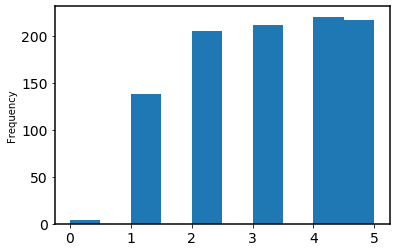

In [11]:
hf['quintile'].plot.hist()

We can either discard the missing values and the lack of cases level; or we can discard the entire variable; or we can conver the values into new categories.

In [0]:
hf.dropna(subset=['quintile'], inplace=True)

In [0]:
#pip install lifelines

In [33]:
var = 'age, gender, copd'.replace(' ', '').split(',') + ['fu_time', 'death']

ethnic = pd.get_dummies(hf['ethnicgroup'], prefix='ethnic', drop_first=True)
quintile = pd.get_dummies(hf['quintile'], prefix='quintile', drop_first=True)
df = pd.concat([ethnic, quintile, hf.loc[:, var]], axis=1)
df.head()

,ethnic_2.0,ethnic_3.0,ethnic_8.0,ethnic_9.0,quintile_1.0,quintile_2.0,quintile_3.0,quintile_4.0,quintile_5.0,age,gender,copd,fu_time,death
id,,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,0,0,90,2,0,416,0
2,0,0,0,0,0,0,0,1,0,74,1,0,648,0
3,0,0,0,0,0,0,1,0,0,83,2,0,466,0
4,0,0,0,0,0,0,0,0,1,79,1,1,441,0
5,0,0,0,0,0,1,0,0,0,94,2,0,371,0


In [34]:
from lifelines import CoxPHFitter
cox = CoxPHFitter()

model = cox.fit(df, 'fu_time', event_col='death')
model.print_summary()

/usr/local/lib/python3.6/dist-packages/lifelines/fitters/coxph_fitter.py:689: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.891. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  ConvergenceWarning,


We see the quintile is not converged with a very large exp coeff and standard error. The reaon for that is the reference level quintile 0 has only 4 cases, and non of them has event. So when other levels refer to level 0, the coeff would be very large, or incomparable.

In [37]:
pd.crosstab(columns=hf['quintile'], index=hf['death']).T

death,0,1
quintile,,
0.0,4,0
1.0,60,78
2.0,111,94
3.0,105,106
4.0,116,104
5.0,109,107


### i) change the reference category for quintile to make it 1 rather than 0

In [39]:
var = 'age, gender, copd'.replace(' ', '').split(',') + ['fu_time', 'death']

ethnic = pd.get_dummies(hf['ethnicgroup'], prefix='ethnic', drop_first=True)
quintile = pd.get_dummies(hf['quintile'], prefix='quintile').iloc[:, [0, 2,3,4,5]]
df = pd.concat([ethnic, quintile, hf.loc[:, var]], axis=1)
df.head()

,ethnic_2.0,ethnic_3.0,ethnic_8.0,ethnic_9.0,quintile_0.0,quintile_2.0,quintile_3.0,quintile_4.0,quintile_5.0,age,gender,copd,fu_time,death
id,,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,0,0,90,2,0,416,0
2,0,0,0,0,0,0,0,1,0,74,1,0,648,0
3,0,0,0,0,0,0,1,0,0,83,2,0,466,0
4,0,0,0,0,0,0,0,0,1,79,1,1,441,0
5,0,0,0,0,0,1,0,0,0,94,2,0,371,0


In [40]:
model = cox.fit(df, 'fu_time', event_col='death')
model.print_summary()

The infinite problems disappeared in quintile 2 to 5, but not in 0. 0 doesn't have any event rate, compared to level 1, it will be infinitely large.

### ii) combine categories (combine quintile 0 with quintile 5)

In [41]:
quintile = hf['quintile'].replace(0, 5)
quintile.value_counts()

5.0    220
4.0    220
3.0    211
2.0    205
1.0    138
Name: quintile, dtype: int64

In [42]:
quintile = pd.get_dummies(quintile, prefix='quintile', drop_first=True)
df = pd.concat([ethnic, quintile, hf.loc[:, var]], axis=1)
df.head()

,ethnic_2.0,ethnic_3.0,ethnic_8.0,ethnic_9.0,quintile_2.0,quintile_3.0,quintile_4.0,quintile_5.0,age,gender,copd,fu_time,death
id,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,90,2,0,416,0
2,0,0,0,0,0,0,1,0,74,1,0,648,0
3,0,0,0,0,0,1,0,0,83,2,0,466,0
4,0,0,0,0,0,0,0,1,79,1,1,441,0
5,0,0,0,0,1,0,0,0,94,2,0,371,0


In [43]:
model=cox.fit(df, 'fu_time', event_col='death')
model.print_summary()

This time we don't see any infinite problem, but combining two sets of patients is not a good option. The two sets of people are probably quite different.

### iii) drop the quintile 0 patients

In [0]:
df = hf.loc[hf.quintile !=0, :]
quintile = pd.get_dummies(df['quintile'], prefix='quintile', drop_first=True)
ethnic = pd.get_dummies(df['ethnicgroup'], prefix='ethnic', drop_first=True)

ndf = pd.concat([ethnic, quintile, df.loc[:, var]], axis=1)

In [62]:
model = cox.fit(ndf, 'fu_time', 'death')
model.print_summary()

The hazard ratio for quintile 5 has gone from 1.08 to 1.11. Not a big change, but it’s quite surprising that the HR has changed at all given that it’s only a question of four patients.